
# Binary Knapsack


## Background

Given a set of items, determine how many items to put in the knapsack to maximize their summed value.

#### Define:

- $x_i$ is the number of items from each type.

- $v_i$ is the value of each item.

- $w_i$ is the weight of each item.

- $D$ is the range of $x$.

Find $x$ that maximizes the value: $\begin{aligned}
\max_{x_i \in D} \Sigma_i v_i x_i\\
\end{aligned}$

and constrained by the weight: $\begin{aligned}
\Sigma_i w_i x_i = C
\end{aligned}$

## Problem Versions

**Binary Knapsack**

Range: $D = \{0, 1\}$

**Integer Knapsack**

Range: $D = [0, b]$


## Knapsack with binary variables and equality constraint


### Define the optimization problem

In [1]:
import numpy as np
import pyomo.environ as pyo


def define_knapsack_model(weights, values, max_weight):
    model = pyo.ConcreteModel()
    num_items = len(weights)

    model.x = pyo.Var(range(num_items), domain=pyo.Binary)

    x_variables = np.array(list(model.x.values()))

    model.weight_constraint = pyo.Constraint(expr=x_variables @ weights == max_weight)

    model.value = pyo.Objective(expr=x_variables @ values, sense=pyo.maximize)

    return model

### Initialize the model with parameters

In [2]:
knapsack_model = define_knapsack_model(
    weights=[2, 3, 2.1, 1, 1, 2], values=[3, 5, 2, 1.5, 1.2, 2.7], max_weight=5
)

## Setting Up the Classiq Problem Instance

In order to solve the Pyomo model defined above, we use the Classiq combinatorial optimization engine. For the quantum part of the QAOA algorithm (`QAOAConfig`) - define the number of repetitions (`num_layers`):

In [3]:
from classiq import construct_combinatorial_optimization_model
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=5)

For the classical optimization part of the QAOA algorithm we define the maximum number of classical iterations (`max_iteration`) and the $\alpha$-parameter (`alpha_cvar`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[3](#cvar)]:

In [4]:
optimizer_config = OptimizerConfig(max_iteration=60, alpha_cvar=0.7)

Lastly, we load the model, based on the problem and algorithm parameters, which we can use to solve the problem:

In [5]:
qmod = construct_combinatorial_optimization_model(
    pyo_model=knapsack_model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

We also set the quantum backend we want to execute on:

In [6]:
from classiq import set_execution_preferences
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

backend_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="aer_simulator")
)

qmod = set_execution_preferences(qmod, backend_preferences)

In [7]:
with open("knapsack_binary.qmod", "w") as f:
    f.write(qmod)

## Synthesizing the QAOA Circuit and Solving the Problem

We can now synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [8]:
from classiq import show, synthesize

qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/5d181ea8-3bed-4465-8c48-9eab0ab1668b?version=0.34.0.dev0%2B124706fb0e


We now solve the problem using the generated circuit by using the `execute` method:

In [9]:
from classiq import execute

res = execute(qprog).result()

We can check the convergence of the run:

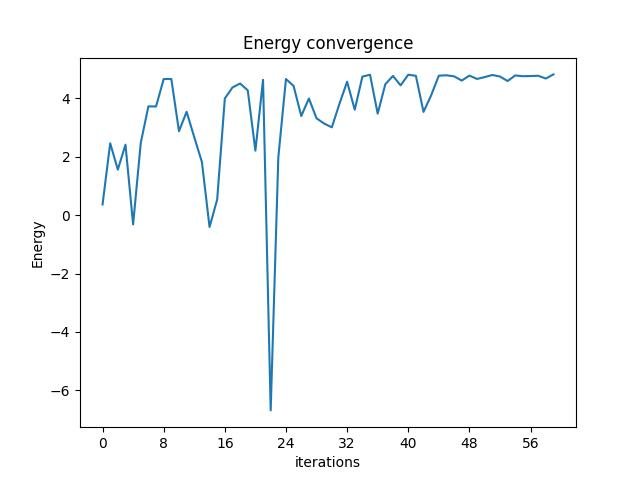

In [10]:
from classiq.execution import VQESolverResult

vqe_result = res[1].value
vqe_result.convergence_graph

# Optimization Results

We can also examine the statistics of the algorithm:

In [11]:
import pandas as pd

optimization_result = pd.DataFrame.from_records(res[0].value)
optimization_result.sort_values(by="cost", ascending=False).head(5)

,probability,cost,solution,count
22,0.015,8.0,"[1, 1, 0, 0, 0, 0]",15
24,0.014,7.7,"[0, 1, 0, 1, 1, 0]",14
47,0.003,7.7,"[0, 1, 0, 0, 0, 1]",3
42,0.004,7.5,"[1, 1, 0, 1, 0, 0]",4
58,0.001,7.2,"[1, 1, 0, 0, 1, 0]",1


And the histogram:

array([[<Axes: title={'center': 'cost'}>]], dtype=object)

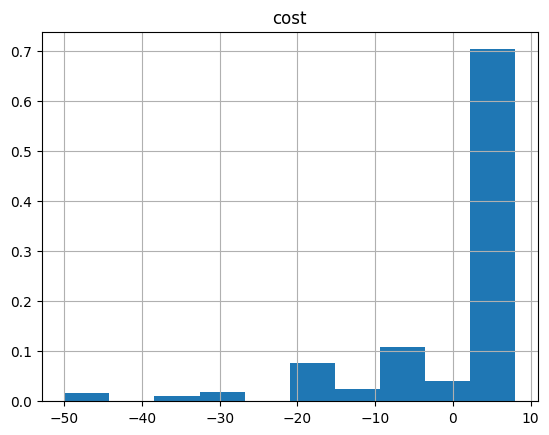

In [12]:
optimization_result.hist("cost", weights=optimization_result["probability"])

Lastly, we can compare to the classical solution of the problem:

In [13]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(knapsack_model)

knapsack_model.display()

Model unknown

  Variables:
    x : Size=6, Index=x_index
        Key : Lower : Value                 : Upper : Fixed : Stale : Domain
          0 :     0 :    0.9999999999999998 :     1 : False : False : Binary
          1 :     0 :                   1.0 :     1 : False : False : Binary
          2 :     0 :                   0.0 :     1 : False : False : Binary
          3 :     0 :                   0.0 :     1 : False : False : Binary
          4 :     0 :                   0.0 :     1 : False : False : Binary
          5 :     0 : 2.220446049250313e-16 :     1 : False : False : Binary

  Objectives:
    value : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True :   8.0

  Constraints:
    weight_constraint : Size=1
        Key  : Lower : Body : Upper
        None :   5.0 :  5.0 :   5.0
